# PREPARE TRAIN

## Pip

In [ ]:
import os
import tqdm
import seaborn as sns
# drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/BERT/SA')

In [ ]:
%%capture
!pip install transformers

In [ ]:
%%capture
!pip install fastBPE
!pip install fairseq
!pip install datasets

In [ ]:
%%capture
# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

text = "Đại học Bách Khoa Hà Nội."

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Đại_học', 'Bách_Khoa', 'Hà_Nội', '.']]


In [ ]:
%%capture
# !wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
# !tar -xzvf PhoBERT_base_transformers.tar.gz

In [ ]:
%%capture
# !wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
# !tar -xzvf PhoBERT_base_fairseq.tar.gz

In [ ]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("PhoBERT_base_transformers/dict.txt")

In [ ]:
bpe.encode("Hôm_nay trời nóng quá nên tôi ở nhà viết Viblo!")

'Hôm_nay trời nóng quá nên tôi ở nhà viết Vi@@ blo@@ !'

In [ ]:
vocab.encode_line('<s> ' + 'Hôm_nay trời nóng quá nên tôi ở nhà viết Vi@@ blo@@ !' + ' </s>')

tensor([    0,  3791,  1027,   898,   204,    77,    70,    25,    69,   467,
         3696, 16856,   381,     2,     2], dtype=torch.int32)

## DF

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('data.csv')
df = df[df.comment != '.']
df = df.reset_index(drop=True)

In [ ]:
# # Bỏ bớt các mẫu có label 'POS'
# n=0
# for i in df.index:
#   if df['label'][i]=='POS':
#     n = n + 1
#     if n%3!=0:
#       df = df.drop([i])
#     if n%3==0:
#       n=0
# df = df.reset_index(drop=True)
# df = df[:-10000]

### vihsd

In [ ]:
df1 = pd.read_csv('vihsd/dev.csv')
df2 = pd.read_csv('vihsd/train.csv')
df3 = pd.read_csv('vihsd/test.csv')

In [ ]:
for i in [df1,df2,df3]:
  i.columns = ['comment','label']

In [ ]:
_df = pd.concat([df1, df2, df3])
_df = _df[_df.label != 0]
_df = _df.dropna()
_df = _df.reset_index(drop=True)
_df.label = 0

### vietnamese_students_feedback

In [ ]:
df_1 = pd.read_csv('vietnamese_students_feedback/validation.csv')
df_2 = pd.read_csv('vietnamese_students_feedback/train.csv')
df_3 = pd.read_csv('vietnamese_students_feedback/test.csv')

In [ ]:
df_ = pd.concat([df_1, df_2, df_3])
df_ = df_.dropna()
df_ = df_.reset_index(drop=True)

In [ ]:
df_

,comment,label
0,giáo trình chưa cụ thể .,0
1,giảng buồn ngủ .,0
2,"giáo viên vui tính , tận tâm .",2
3,"giảng viên nên giao bài tập nhiều hơn , chia n...",0
4,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",0
...,...,...
16170,"các slide khó hiểu , ngôn ngữ trong slide phức...",0
16171,giáo viên giảng dạy có tâm huyết .,2
16172,chia sẻ cho em nhiều điều hay .,2
16173,em tiếp thu chậm .,0


### Concat

In [ ]:
df['label'] = np.where(df['label']=='NEG',0,np.where(df['label']=='NEU',1,2))
df = df[['comment','label']]

df_train = pd.concat([df[:-2000] , _df[:5300], df_[:-1100]])
df_train = df_train.sample(frac = 1) # Shuffle
df_train = df_train.reset_index(drop=True)
df_train['comment'].astype(str)

df_test = pd.concat([df[-2000:] , _df[5300:], df_[-1100:]])
df_test = df_test.sample(frac = 1)   # Shuffle
df_test = df_test.reset_index(drop=True)
df_test['comment'].astype(str)

0                 Đóng gói sản phẩm rất đẹp và chắc chắn.
1       Toan đựng bọn ngu phá hại lên làm quan nên dân...
2                    Sản phẩm đẹp lắm ạ, rất đáng để mua.
3       ở ngoài tao mà gặp kiểu này t bắt lại cho anh ...
4                          Áo vải đẹp, form quá ưng luôn.
                              ...                        
3570    - Sản Phẩm Tuyệt Vời :v Chị Shop Phụ Phụ Rất T...
3571                           Mua đồ chỗ shop ưng ý lắm.
3572    cô dạy dễ hiểu , giải bài tập hướng dẫn chúng ...
3573    Cá chết vẫn chưa rõ nguyên nhân, biển thì vẫn ...
3574    Ai đã sử dụng hàng Mỹ rồi thì chỉ cần ngửi mùi...
Name: comment, Length: 3575, dtype: object

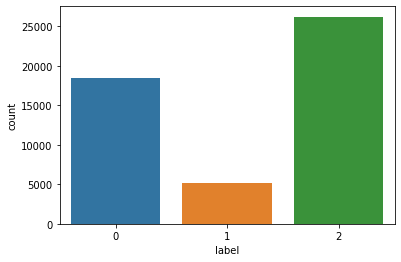

In [ ]:
sns.countplot(x='label', data=df_train)

## Split train test eval

In [ ]:
def concat_cmt(text):
  cmt = ''
  cmt = text[0][0]
  for i in text[0][1:]:
    if i in [',','.','!','?']:
      cmt = cmt + i 
    else:
      cmt = cmt + ' ' + i 
  return cmt

In [ ]:
train_text = []
train_labels = []
for i in tqdm.notebook.tqdm(df_train.index):
  try:
    train_text.append(concat_cmt(rdrsegmenter.tokenize(df_train.iloc[i]['comment'])))
    train_labels.append(df_train.iloc[i]['label'])
  except:
    print(df_train.iloc[i]['comment'])
    break

test_text = []
test_labels = []
for i in tqdm.notebook.tqdm(df_test.index):
  try:
    test_text.append(concat_cmt(rdrsegmenter.tokenize(df_test.iloc[i]['comment'])))
    test_labels.append(df_test.iloc[i]['label'])
  except:
    print(df_test.iloc[i]['comment'])
    break


In [ ]:
from sklearn.model_selection import train_test_split

train_sents, val_sents, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.1)

## Create Ids

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 125

train_ids = []
for sent in train_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encoded_sent)

val_ids = []
for sent in val_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    val_ids.append(encoded_sent)
    
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

## Create Mask

In [ ]:
train_masks = []
for sent in train_ids:
    mask = [int(token_id > 0) for token_id in sent]
    train_masks.append(mask)

val_masks = []
for sent in val_ids:
    mask = [int(token_id > 0) for token_id in sent]
    val_masks.append(mask)

## Create DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

config = RobertaConfig.from_pretrained(
    "PhoBERT_base_transformers/config_2.json", from_tf=False, num_labels = 3, output_hidden_states=False,
)
BERT_SA = RobertaForSequenceClassification.from_pretrained(
    "PhoBERT_base_transformers/model.bin",
    config=config
    # num_labels = 3
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

In [ ]:
BERT_SA.cuda()
print('Done')

Done


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='weighted')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

# TRAIN

In [ ]:
import random
import tqdm
device = 'cuda'
epochs = 3

param_optimizer = list(BERT_SA.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False, no_deprecation_warning=True)

best_eval = 0
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    BERT_SA.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    
    for step, batch in tqdm.notebook.tqdm(enumerate(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        BERT_SA.zero_grad()
        outputs = BERT_SA(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(BERT_SA.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))

    print("Running Validation...")
    BERT_SA.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    
    for batch in val_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = BERT_SA(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1

    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
    if (eval_accuracy/nb_eval_steps) > best_eval:
      best_eval = (eval_accuracy/nb_eval_steps)
      BERT_SA.save_pretrained(f'bert_pretrain/')
      print('Saved Best Model!')

print("Training complete!")
# BERT_SA.save_pretrained('bert_pretrain/')
# print('Saved Pretrain!')

======== Epoch 1 / 3 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.7890
 F1 score: 0.8224
 Average training loss: 0.5274
Running Validation...
 Accuracy: 0.8333
 F1 score: 0.8599
Saved Best Model!
======== Epoch 2 / 3 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8452
 F1 score: 0.8636
 Average training loss: 0.3984
Running Validation...
 Accuracy: 0.8429
 F1 score: 0.8583
Saved Best Model!
======== Epoch 3 / 3 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8642
 F1 score: 0.8764
 Average training loss: 0.3511
Running Validation...
 Accuracy: 0.8457
 F1 score: 0.8578
Saved Best Model!
Training complete!


# LOAD

In [ ]:
config2 = RobertaConfig.from_pretrained(
    "PhoBERT_base_transformers/config_2.json", from_tf=False, num_labels = 3, output_hidden_states=False,
)
BERT_SA2 = RobertaForSequenceClassification.from_pretrained(
    "bert_pretrain/",
    config=config2
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


In [ ]:
%%capture
from transformers import AutoTokenizer
tkn = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment", use_fast=False)

In [ ]:
def BERT_Predict(text):
  """
  ['NEG', 'NEU', 'POS']
  [' 0 ', ' 1 ', ' 2 ']
  """
  inputs = tkn(text, return_tensors="pt")

  with torch.no_grad():
      logits = BERT_SA2(**inputs).logits
  predicted_class_id = logits.argmax().item()
  # predicted_class_id = logits.softmax(dim=-1).tolist()
  return predicted_class_id
  
# class_names = ['NEG', 'NEU', 'POS']
# print(class_names[predicted_class_id])

In [ ]:
test_pred = []
for cmt in test_text:
  test_pred.append(BERT_Predict(cmt))

In [ ]:
def flat_accuracy(preds, labels):
  preds = np.array(preds)
  labels = np.array(labels)
  F1_weighted = f1_score(preds, labels, average='weighted')
  print('Acc: ',accuracy_score(preds, labels), '\nf1 weighted: ', F1_weighted)

In [ ]:
flat_accuracy(test_pred,test_labels)

Acc:  0.8553846153846154 
f1 weighted:  0.8530413449325531


In [ ]:
BERT_Predict('Không có lỗi và rất đáng tiền.')

2

In [ ]:
df_result = pd.DataFrame({'comment': test_text, 'label': test_pred, 'predict': test_labels})
df_result

,comment,label,predict
0,Đóng_gói sản_phẩm rất đẹp và chắc_chắn.,2,2
1,Toan đựng bọn ngu phá_hại lên làm quan nên dân...,0,0
2,"Sản_phẩm đẹp lắm ạ, rất đáng để mua.",2,2
3,ở ngoài tao mà gặp kiểu này t bắt lại cho anh ...,0,0
4,"Áo vải đẹp, form quá ưng luôn.",2,2
...,...,...,...
3570,- Sản_Phẩm Tuyệt_Vời : v Chị Shop_Phụ_Phụ_Rất ...,2,2
3571,Mua đồ chỗ shop ưng_ý lắm.,2,2
3572,"cô dạy dễ hiểu, giải bài_tập hướng_dẫn chúng_e...",2,2
3573,"Cá chết vẫn chưa rõ nguyên_nhân, biển thì vẫn ...",0,0
